In [1]:
import biotite.structure.io as bsio
import csv
#import esm
import os
import pandas as pd
import random
import torch
from tqdm import tqdm
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from Bio.PDB import PDBParser

def extract_b_factors(pdb_file, residues):
    parser = PDBParser()
    structure = parser.get_structure('structure', pdb_file)
    
    b_factors = {}
    
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_id()[1] in residues:
                    for atom in residue:
                        atom_id = (chain.get_id(), residue.get_id()[1], atom.get_id())
                        b_factors[atom_id] = atom.get_bfactor()
    
    return list(b_factors.values())

## pLDDT analysis for EvoDiff TCRs

In [9]:
plddt_folded_seqs = pd.read_csv('../results/plddt_results.csv').iloc[:,0]
all_evodiff_seqs = pd.read_csv('../results/trbv_gen.csv')

In [10]:
cdr_idxs = []
for seq in plddt_folded_seqs:
    left_context = list(all_evodiff_seqs.loc[all_evodiff_seqs.sequence == seq, 'left_context'])[0]
    right_context = list(all_evodiff_seqs.loc[all_evodiff_seqs.sequence == seq, 'right_context'])[0]
    left_cdr_index = seq.index(left_context) + len(left_context) - 5
    right_cdr_index = seq.index(right_context)
    cdr_idxs.append((left_cdr_index, right_cdr_index))

In [26]:
avg_cdr_plddt = []
for i in range(len(cdr_idxs)):
    pdb_file = f"../results/structures/prot{i+1}.pdb"
    residues_of_interest = np.arange(cdr_idxs[i][0]+1, cdr_idxs[i][1]+1)  # Example residues of interest
    b_factors = extract_b_factors(pdb_file, residues_of_interest)
    avg_cdr_plddt.append(np.mean(b_factors))

Text(0.5, 1.0, 'CDR3 pLDDT score - EvoDiff')

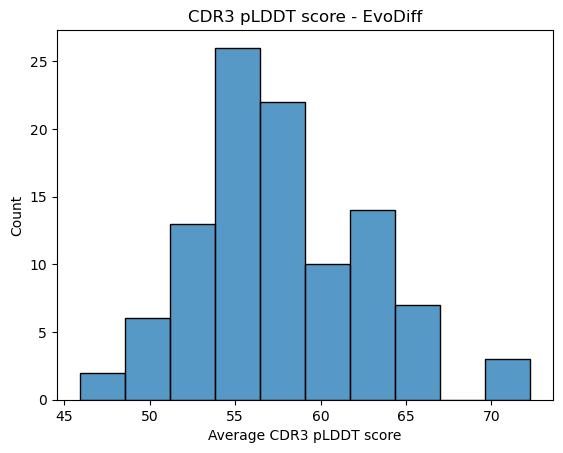

In [27]:
sns.histplot(avg_cdr_plddt)
plt.xlabel('Average CDR3 pLDDT score')
plt.title('CDR3 pLDDT score - EvoDiff')

In [34]:
print(np.mean(avg_cdr_plddt))

57.53932845123949


In [28]:
plddt_results_evodiff = pd.DataFrame({'sequence':plddt_folded_seqs, 'avg_plddt':avg_cdr_plddt})

In [29]:
plddt_results_evodiff.to_csv('../results/evodiff_plddt_results.csv')

## LSTM pLDDT score

In [24]:
lstm_seqs = pd.read_csv('../results/lstm_gen.csv', header=None)
lstm_cdr_idxs = []
for i in range(137):
    cdr, v_region, _ = list(lstm_seqs.iloc[i, :])
    lstm_cdr_idxs.append((len(v_region), len(v_region) + len(cdr)))

In [31]:
avg_cdr_plddt_lstm = []
for i in range(137):
    pdb_file = f"../results/lstm_structures/prot{i}.pdb"
    residues_of_interest = np.arange(lstm_cdr_idxs[i][0]+1, lstm_cdr_idxs[i][1]+1)  # Example residues of interest
    b_factors = extract_b_factors(pdb_file, residues_of_interest)
    avg_cdr_plddt_lstm.append(np.mean(b_factors))

Text(0.5, 1.0, 'CDR3 pLDDT score - LSTM')

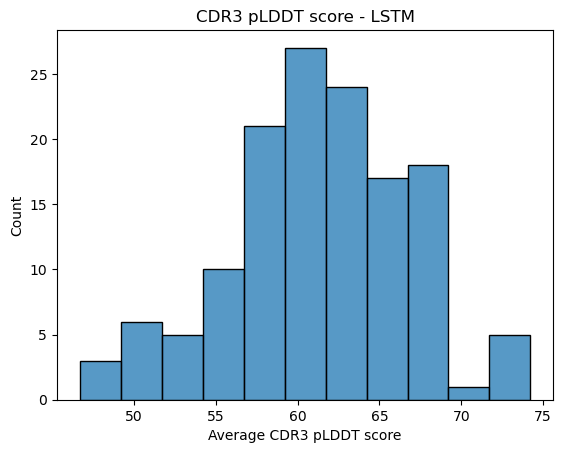

In [32]:
sns.histplot(avg_cdr_plddt_lstm)
plt.xlabel('Average CDR3 pLDDT score')
plt.title('CDR3 pLDDT score - LSTM')

In [50]:
plddt_results_lstm = pd.DataFrame({'sequence':list(lstm_seqs.iloc[:137, 1]), 'avg_plddt':avg_cdr_plddt_lstm})
plddt_results_lstm.to_csv('../results/lstm_plddt_results.csv')

In [33]:
print(np.mean(avg_cdr_plddt_lstm))

61.25164726750195


## Native TCR

In [37]:
native_tcr_seqs = pd.read_csv('../data/native_TCRbeta_seqs.csv', index_col='n')

In [41]:
native_cdr_idxs = []
for i in range(native_tcr_seqs.shape[0]):
    cdr, seq = list(native_tcr_seqs.iloc[i, :])[2:]
    native_cdr_idxs.append((seq.index(cdr), seq.index(cdr) + len(cdr)))

In [43]:
avg_cdr_plddt_native = []
for i in range(100):
    pdb_file = f"../results/lstm_structures/prot{i}.pdb"
    residues_of_interest = np.arange(lstm_cdr_idxs[i][0]+1, lstm_cdr_idxs[i][1]+1)  # Example residues of interest
    b_factors = extract_b_factors(pdb_file, residues_of_interest)
    avg_cdr_plddt_native.append(np.mean(b_factors))

In [53]:
np.mean(avg_cdr_plddt_native)

61.54628223927433

Text(0.5, 1.0, 'CDR3 pLDDT score - Native TCR Sequences')

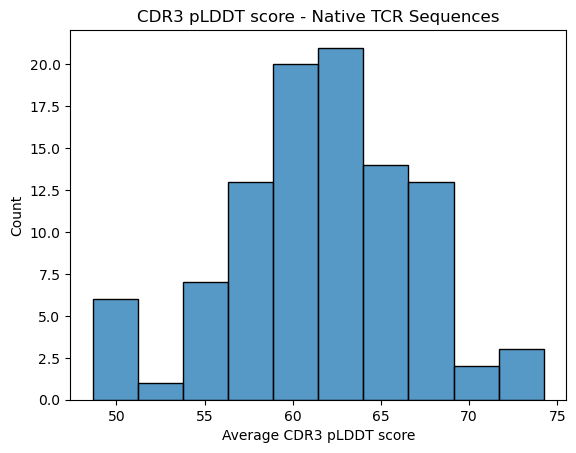

In [54]:
sns.histplot(avg_cdr_plddt_native)
plt.xlabel('Average CDR3 pLDDT score')
plt.title('CDR3 pLDDT score - Native TCR Sequences')

In [56]:
plddt_results_lstm = pd.DataFrame({'sequence':list(native_tcr_seqs.iloc[:, 3]), 'avg_plddt':avg_cdr_plddt_native})
plddt_results_lstm.to_csv('../results/native_plddt_results.csv')